In [1]:
import sys
sys.path.append('../')

In [2]:
import pickle
import numpy as np
import pandas as po
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

In [3]:
from scipy.interpolate import interp1d
from numpy import arange, exp

In [4]:
from filepaths import fp

In [5]:
df = po.read_csv('../'+fp.imputation_raw)

In [6]:
df

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31,num_zeros,FLAG
0,0.003306,0.005092,0.004084,0.002153,0.002118,0.002233,0.002193,0.002183,0.002754,0.002912,...,0.000711,0.000954,0.000763,0.000935,0.000706,0.000838,0.001079,0.001154,0,0
1,0.002839,0.002636,0.001719,0.000802,0.001172,0.001789,0.001347,0.001796,0.001463,0.001856,...,0.000536,0.000574,0.000536,0.000528,0.000357,0.000219,0.000523,0.000632,160,0
2,0.001043,0.001152,0.001260,0.000765,0.001356,0.001947,0.001788,0.002352,0.001590,0.002390,...,0.000389,0.000409,0.000522,0.000340,0.000028,0.000030,0.000123,0.000136,0,0
3,0.003647,0.004900,0.003473,0.002046,0.002234,0.002423,0.002611,0.004230,0.000000,0.000000,...,0.000921,0.000646,0.001120,0.000639,0.000595,0.000465,0.000907,0.000368,106,0
4,0.004756,0.004716,0.004660,0.002529,0.002707,0.003427,0.002706,0.003627,0.002892,0.003371,...,0.000833,0.001026,0.000962,0.000762,0.000782,0.000791,0.000898,0.001173,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24267,0.002694,0.002704,0.003149,0.001000,0.001347,0.001487,0.001405,0.002146,0.001875,0.001775,...,0.000437,0.000709,0.000591,0.000555,0.000415,0.000524,0.000627,0.000546,0,0
24268,0.000648,0.000892,0.000438,0.000416,0.000146,0.000177,0.000132,0.000161,0.000161,0.000514,...,0.000110,0.000206,0.000345,0.000106,0.000132,0.000133,0.000124,0.000172,0,1
24269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.000009,...,0.000338,0.000378,0.000241,0.000302,0.000230,0.000325,0.000367,0.000459,199,0
24270,0.000630,0.001240,0.001197,0.000547,0.000635,0.000717,0.000724,0.000964,0.000711,0.000819,...,0.000298,0.000466,0.000352,0.000280,0.000278,0.000308,0.000280,0.000481,0,0


In [7]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [8]:
def interpolate_gaps(x):
    x_filled = x.copy()
    missing_seqs = find_gaps(x)
    
    for seq in missing_seqs:
        len_gap = seq[1] - seq[0]
        
        if seq[0]-len_gap < 0 and seq[1]+len_gap > len(x): # Gap at both ends. Ignore this row for now.
            continue
            
        elif seq[0]-len_gap < 0: # Gap at start only. Make interpolator from right and extrapolate to fill
            if seq[1]+2*len_gap < len(x):
                interpfunk = interp1d(list(range(seq[1], seq[1]+2*len_gap)), x[seq[1]:seq[1]+2*len_gap], fill_value='extrapolate') # Take twice as much from the available side (if possible)
               
            elif seq[1]+len_gap < len(x):
                interpfunk = interp1d(list(range(seq[1], seq[1]+len_gap)), x[seq[1]:seq[1]+len_gap], fill_value='extrapolate') 
                
            else:
                continue # Gap is too large. Ignore this row for now.
            
        elif seq[1]+len_gap > len(x): # Gap at end only. Make interpolator from left and extrapolate to fill
            if seq[0]-2*len_gap > 0:
                interpfunk = interp1d(list(range(seq[0]-2*len_gap, seq[0])), x[seq[0]-2*len_gap:seq[0]], fill_value='extrapolate')  # Take twice as much from the available side (if possible)
            
            elif seq[0]-len_gap > 0:
                interpfunk = interp1d(list(range(seq[0]-len_gap, seq[0])), x[seq[0]-len_gap:seq[0]], fill_value='extrapolate') 
            
            else:
                continue # Gap is too large. Ignore this row for now.
            
        else:
            interpfunk = interp1d(list(range(seq[0]-len_gap, seq[0])) + list(range(seq[1], seq[1]+len_gap)), x[seq[0]-len_gap:seq[0]] + x[seq[1]:seq[1]+len_gap]) 
    
        for i in range(len_gap):
            x_filled[seq[0]+i] = interpfunk(seq[0]+i).item()
            
    return x_filled

In [9]:
def impute_row(i):
    x = df.iloc[i][:-2].to_list()
    return interpolate_gaps(x)    

In [10]:
p = multiprocessing.Pool() 
new_rows = list(tqdm(p.imap(impute_row, list(range(len(df)))), total=len(df)))

100%|██████████| 24272/24272 [00:21<00:00, 1145.95it/s]


In [11]:
df_interp = po.DataFrame(new_rows)

In [12]:
df_interp.columns = df.columns[:-2]

In [13]:
df_interp

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
0,0.003306,0.005092,0.004084,0.002153,0.002118,0.002233,0.002193,0.002183,0.002754,0.002912,...,0.001007,0.000905,0.000711,0.000954,0.000763,0.000935,0.000706,0.000838,0.001079,0.001154
1,0.002839,0.002636,0.001719,0.000802,0.001172,0.001789,0.001347,0.001796,0.001463,0.001856,...,0.000434,0.000277,0.000536,0.000574,0.000536,0.000528,0.000357,0.000219,0.000523,0.000632
2,0.001043,0.001152,0.001260,0.000765,0.001356,0.001947,0.001788,0.002352,0.001590,0.002390,...,0.000379,0.000532,0.000389,0.000409,0.000522,0.000340,0.000028,0.000030,0.000123,0.000136
3,0.003647,0.004900,0.003473,0.002046,0.002234,0.002423,0.002611,0.004230,-0.001939,-0.001367,...,0.001479,0.001695,0.000921,0.000646,0.001120,0.000639,0.000595,0.000465,0.000907,0.000368
4,0.004756,0.004716,0.004660,0.002529,0.002707,0.003427,0.002706,0.003627,0.002892,0.003371,...,0.000977,0.001023,0.000833,0.001026,0.000962,0.000762,0.000782,0.000791,0.000898,0.001173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24267,0.002694,0.002704,0.003149,0.001000,0.001347,0.001487,0.001405,0.002146,0.001875,0.001775,...,0.000548,0.000742,0.000437,0.000709,0.000591,0.000555,0.000415,0.000524,0.000627,0.000546
24268,0.000648,0.000892,0.000438,0.000416,0.000146,0.000177,0.000132,0.000161,0.000161,0.000514,...,0.000143,0.000141,0.000110,0.000206,0.000345,0.000106,0.000132,0.000133,0.000124,0.000172
24269,0.000050,0.000045,0.000041,0.000036,0.000032,0.000027,0.000023,0.000018,0.000014,0.000009,...,0.000389,0.000405,0.000338,0.000378,0.000241,0.000302,0.000230,0.000325,0.000367,0.000459
24270,0.000630,0.001240,0.001197,0.000547,0.000635,0.000717,0.000724,0.000964,0.000711,0.000819,...,0.000289,0.000482,0.000298,0.000466,0.000352,0.000280,0.000278,0.000308,0.000280,0.000481


In [14]:
num_zeros = []
for i in tqdm(range(len(df_interp))):
    num_zeros.append(df_interp.iloc[i].to_list().count(0))

100%|██████████| 24272/24272 [00:02<00:00, 9448.83it/s]


In [15]:
df_interp['num_zeros'] = num_zeros

In [16]:
df_interp['num_zeros']

0        0
1        0
2        0
3        0
4        0
        ..
24267    0
24268    0
24269    0
24270    0
24271    0
Name: num_zeros, Length: 24272, dtype: int64

In [17]:
df['num_zeros']

0          0
1        160
2          0
3        106
4          0
        ... 
24267      0
24268      0
24269    199
24270      0
24271      2
Name: num_zeros, Length: 24272, dtype: int64

In [18]:
df_interp['FLAG'] = df['FLAG']

In [19]:
df_interp.to_csv('../data/processed/imputation/interp.csv', index=False)

In [5]:
df = po.read_csv('../'+fp.imputation_raw)
df_interp = po.read_csv('../' + fp.interp_imputed_df)

In [22]:
i = 24269

In [23]:
df[df==0]=None

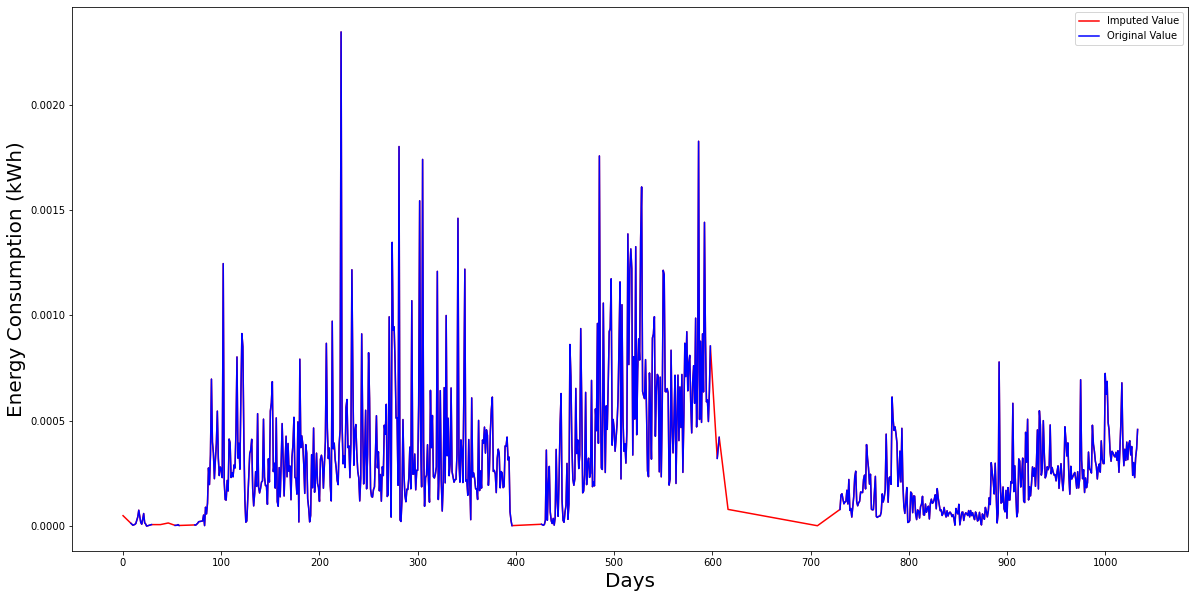

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(df_interp.iloc[i][:-2], color='red')
plt.plot(df.iloc[i][:-2], color='blue')
plt.xticks(range(0, len(df.iloc[i][:-2]), 100), range(0, len(df.iloc[i][:-2]), 100)) 
plt.xlabel('Days', fontsize=20)
plt.ylabel('Energy Consumption (kWh)', fontsize=20)
plt.legend(['Imputed Value', 'Original Value'])
plt.savefig('../plots/impute/interpolate.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[28][:-2], color='red')
plt.plot(df_edtwbi_impute.iloc[28][:-2], color='blue')
plt.xticks(range(0, len(df.iloc[28][:-2]), 100), range(0, len(df.iloc[28][:-2]), 100)) 
plt.xlabel('Days', fontsize=20)
plt.ylabel('Energy Consumption (kWh)', fontsize=20)
plt.legend(['Before Imputation', 'After Imputation'])
plt.savefig('../plots/impute/eDTWBI.png')